In [33]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

# Lecture 12, Methods for multiobjective optimization-part 2

##  Our example problem for this lecture

We study a hypothetical decision problem of buying a car, when you can choose to have a car with power between (denoted by $p$) 50 and 200 kW and average consumption (denoted by $c$) per 100 km between 3 and 10 l. However, in addition to the average consumption and power, you need to decide the volume of the cylinders (v), which may be between 1000 $cm^3$ and 4000 $cm^3$. Finally, the price of the car follows now a function 

$$
\left(\sqrt{\frac{p-50}{50}}\\
+\left(\frac{p-50}{50}\right)^2+0.3(10-c)\\ +10^{-5}\left(v-\left(1000+3000\frac{p-50}{150}\right)\right)^2\right)10000\\+5000
$$

in euros. This problem can be formulated as a multiobjective optimization problem

$$
\begin{align}
\min \quad & \{c,-p,P\},\\
\text{s.t. }\quad
&50\leq p\leq 200\\
&3\leq c\leq 10\\
&1000\leq v\leq 4000,\\
\text{where }\quad&P = \left(\sqrt{\frac{p-50}{50}}+\left(\frac{p-50}{50}\right)^2+0.3(10-c)\right.\\
& \left.+ 10^{-5}\left(v-\left(1000+3000\frac{p-50}{150}\right)\right)^2\right)10000+5000
\end{align}
$$

In [34]:
#Let us define a Python function which returns the value of this
import math
def car_problem(c,p,v):
#    import pdb; pdb.set_trace()
    return [#Objective function values
        c,-p,
        (math.sqrt((p-50.)/50.)+((p-50.)/50.)**2+
        0.3*(10.-c)+0.00001*(v-(1000.+3000.*(p-50.)/150.))**2)*10000.
        +5000.] 

### Normalized car problem

In [35]:
#Let us define a Python function which returns the value of this
import math
def car_problem_normalized(c,p,v):
    z_ideal = [3.0, -200.0, 5000]
    z_nadir = [10,-50,1033320.5080756888]
#    import pdb; pdb.set_trace()
    z = car_problem(c,p,v) 
    return [(zi-zideali)/(znadiri-zideali) for 
            (zi,zideali,znadiri) in zip(z,z_ideal,z_nadir)]

In [36]:
z_ideal = [3.0, -200.0, 5000]
z_nadir = [10.,-50,1033320.5080756888]

**From now on, we will deal with the normalized problem, although, we write just $f$.** The aim of this is to simplify presentation.

## No preference methods

* Usually only for situations, where the decision maker is not available or does not want to get involved
* These just compute a single Pareto optimal solution, which is in somehow mathematically thought as the best compromise

## Notation

For short, let us denote the feasible set as $S = \{x\in\mathbb R^n: g_j(x) \geq 0 \text{ for all }j=1,\ldots,J \text{ and } h_k(x) = 0\text{ for all }k=1,\ldots,K\}$.

### Method of Global criterion

Involved minimization of the p-norm of $f(x)-z^{ideal}$, that is we solve the problem

$$
\min_{x\in S} \|f(x) - z^{ideal}\|_p
$$

![alt text](images/mgc.svg "Method of global criterion")

**An optimal solution to this problem is Pareto optimal**

### Applying to our problem studied


In [37]:
import numpy as np
from scipy.optimize import minimize
import ad
def global_criterion_method(f,p):
    #Ideal for any normalized problem is (0,0,0)
    ideal = [0,0,0]
    bounds = ((3,10),(50,200),(1000,4000)) #Variable bounds of the problem
    #Objective is the norm of objective function values minus
    #the ideal
    obj = lambda x: np.linalg.norm(np.array(f(x[0],x[1],x[2]))
                                   -np.array(ideal),ord=p)
    start = [7,125,2500] #starting values for the variables
    res=minimize(
            #Minimize p distance from the ideal
            obj, start, method='SLSQP'
            #Jacobian using automatic differentiation
            ,jac=ad.gh(obj)[0]
            #bounds given above
            ,bounds = bounds,options = {'disp':True})
    return res.x

In [38]:
degree = 2
solution = global_criterion_method(car_problem_normalized,
                                           degree)
print("variable values are ",solution)
f_global_criterion = car_problem(solution[0],solution[1],solution[2])
print("objective values are ",f_global_criterion)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2550330331982373
            Iterations: 13
            Function evaluations: 22
            Gradient evaluations: 13
variable values are  [   3.02944133  176.80589468 2500.00083783]
objective values are  [3.029441328653617, -176.8058946793659, 213509.66458173335]


In [39]:
help (np.linalg.norm)

Help on function norm in module numpy.linalg:

norm(x, ord=None, axis=None, keepdims=False)
    Matrix or vector norm.
    
    This function is able to return one of eight different matrix norms,
    or one of an infinite number of vector norms (described below), depending
    on the value of the ``ord`` parameter.
    
    Parameters
    ----------
    x : array_like
        Input array.  If `axis` is None, `x` must be 1-D or 2-D, unless `ord`
        is None. If both `axis` and `ord` are None, the 2-norm of
        ``x.ravel`` will be returned.
    ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
        Order of the norm (see table under ``Notes``). inf means numpy's
        `inf` object. The default is None.
    axis : {None, int, 2-tuple of ints}, optional.
        If `axis` is an integer, it specifies the axis of `x` along which to
        compute the vector norms.  If `axis` is a 2-tuple, it specifies the
        axes that hold 2-D matrices, and the matrix norms of these

In [40]:
solution = global_criterion_method(car_problem_normalized,
                                           np.inf)
print("variable values are ",solution) 
f_global_criterion = car_problem(solution[0],solution[1],solution[2])
print("objective values are ",f_global_criterion)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.18028203269723292
            Iterations: 26
            Function evaluations: 69
            Gradient evaluations: 26
variable values are  [   4.25892988  172.95999244 2500.00213198]
objective values are  [4.258929879857968, -172.95999243905936, 190387.71146013652]


## A posteriori methods

* A posteriori methods generate a representation of the Pareto optimal solutions, or the complete set of Pareto optimal solutions
* Benefits
  * The solutions can be visualized for problems with 2 or 3 objectives so the decision making is possible
  * When succesful, they give an understanding of the Pareto front
* Drawbacks
  * Approximating the Pareto optimal set often time-consuming
  * Decision making from a large representation may be very difficut


### The weighting method

Based on solving optimization problem
$$
\min_{x\in S} \sum_{i=1}^kw_if_i(x)
$$
for different weights $w_i\geq0$, $i=1,\ldots,k$ such that $\sum_{i=1}^k w_i=1$. 

**The idea is to generate weights evenly and then have evenly spread solutions.**

**An optimal solution of the weighted problem is Pareto optimal, if all the weights $w_i$ are $>0$.**

![alt text](images/ws.svg "Weighting method")

### Application to our problem

In [41]:
import numpy as np
def weighting_method(f,w):
    points = []
    bounds = ((3,10),(50,200),(1000,4000)) #variable bounds of the problem
    start = [7,125,2500] #starting values for the variables 
    for wi in w:
        res=minimize(
            #weighted sum
            lambda x: sum(np.array(wi)*np.array(f(x[0],x[1],x[2]))), 
            start, method='SLSQP'
            #Jacobian using automatic differentiation
            ,jac=ad.gh(lambda x: sum(np.array(wi)*np.array(f(x[0],x[1],x[2]))))[0]
            #bounds given above
            ,bounds = bounds,options = {'disp':False})
        points.append(res.x)
    return points

In [42]:
w = np.random.random ((500,3)) #500 random weights 

In [43]:
help(np.random.random) 

Help on built-in function random:

random(...) method of numpy.random.mtrand.RandomState instance
    random(size=None)
    
    Return random floats in the half-open interval [0.0, 1.0). Alias for
    `random_sample` to ease forward-porting to the new random API.



In [44]:
# normalize the weights
wn = w
for i in range(len(w)):
    s = sum(w[i])
    for j in range(2):
        wn[i][j] = w[i][j]/s

In [45]:
print(wn)

[[0.30775757 0.13578172 0.83478274]
 [0.43260626 0.33394713 0.39797133]
 [0.13496065 0.4745223  0.74104226]
 ...
 [0.48231806 0.1838959  0.50087782]
 [0.57113275 0.17477249 0.36089137]
 [0.24162153 0.2981989  0.58015565]]


In [46]:
repr = weighting_method(car_problem_normalized,wn)

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def visualize_representation(func,repr):
    f_repr = [func(repri[0],repri[1],repri[2]) for repri in repr]
    print(min(f_repr))
    print(max(f_repr))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([f[0] for f in f_repr],[f[1] for f in f_repr],[f[2] for f in f_repr])
    return plt

[3.0, -200.0, 358301.09800968756]
[10.0, -124.96468779000863, 39723.43268440647]


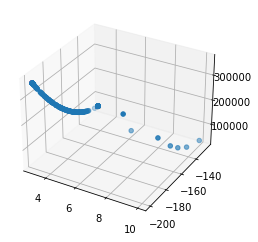

In [48]:
visualize_representation(car_problem,repr).show()

### Epsilon-constraint method



Based on solving optimization problem

$$
\begin{align}
\min \quad &f_j(x)\\
\text{s.t. }\quad &x\in S\\
&f_i(x)\leq \epsilon_i \text{ for all }i\neq j
\end{align}
$$

for different bounds $\epsilon_i, i\neq j$. 

* In other words, select one of the objectives ($f_j$) to be optimized and convert others as constraints by giving them an upper bound ($f_i(x)\leq \epsilon_i$).

* Different PO solutions can be obtained by changing the bounds and/or the objective to be optimized!

**The idea is to generate $\epsilon$ evenly within the bounds of the ideal and nadir vectors and then have evenly spread solutions.**

**A solution $x^*$ is Pareto optimal, if it is the solution to the epsilon constraint problem for all $j=1,\ldots,k$ and $\epsilon = f(x^*)$.**

![alt text](images/eps.svg "Epsilon constraint method")

### Ilustrative example 

PO solutions for different upper bounds for $𝑓_2$.
![](images/eg-epsilon-constraint.jpg)

$$
𝜖_1 → \text{no solutions}\\
𝜖_2 → 𝐳^2\\
𝜖_3 → 𝐳^3\\
𝜖_4 → 𝐳^4
$$

### Application to our problem

In [49]:
import numpy as np
from scipy.optimize import minimize
import ad
def e_constraint_method(f,eps,z_ideal,z_nadir):
    points = []
    start = [7,125,2500]
    for epsi in eps:
        bounds = ((3,epsi[0]*(z_nadir[0]-z_ideal[0])+z_ideal[0]), # f1(x) = (c-z1^ideal)/(z1^nadir-z1^ideal) <= eps_1
                  (-1.*(epsi[1]*(z_nadir[1]-z_ideal[1])+z_ideal[1]), # f2(x) = (-p-z2^ideal)/(z2^nadir-z2^ideal) <= eps_2
                   200),(1000,4000)) #Added bounds for two first objectives
        res=minimize(
            #minimize the third objective = Price
            lambda x: f(x[0],x[1],x[2])[2], 
            start, method='SLSQP'
            #Jacobian using automatic differentiation
            ,jac=ad.gh(lambda x: f(x[0],x[1],x[2])[2])[0]
            #bounds given above
            ,bounds = bounds,options = {'disp':False})
        if res.success:
            points.append(res.x)
    return points

In [50]:
eps = np.random.random((2000,2))
repr_eps = e_constraint_method(car_problem_normalized,eps,z_ideal,z_nadir)

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def visualize_representation(func,repr):
    f_repr = [func(repri[0],repri[1],repri[2]) for repri in repr]
    print(min(f_repr))
    print(max(f_repr))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([f[0] for f in f_repr],[f[1] for f in f_repr],[f[2] for f in f_repr])
    return plt

[3.0043671318335354, -125.0, 60734.34731841528]
[9.997893054569932, -124.40010789668045, 39360.58924203135]


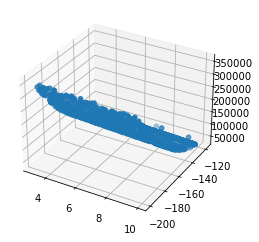

In [52]:
visualize_representation(car_problem,repr_eps).show()

## Comparison of the weighted sum method and the epsilon constraint method

In [53]:
import numpy as np
def weighting_method(f,w):
    points = []
    bounds = ((3,10),(50,200),(1000,4000)) #Bounds of the problem
    start = [7,125,2500]
    for wi in w:
        res=minimize(
            #weighted sum
            lambda x: sum(np.array(wi)*np.array(f(x[0],x[1],x[2]))), 
            start, method='SLSQP'
            #Jacobian using automatic differentiation
            ,jac=ad.gh(lambda x: sum(np.array(wi)*np.array(f(x[0],x[1],x[2]))))[0]
            #bounds given above
            ,bounds = bounds,options = {'disp':False})
        points.append(res.x)
    return points

In [54]:
w = np.random.random((2000,3)) #500 random weights
wn = w # normalized weights
for i in range(len(w)):
    s = sum(w[i])
    for j in range(3):
        wn[i][j] = w[i][j]/s
repr_ws = weighting_method(car_problem_normalized,wn)
#repr_ws = weighting_method(car_problem_normalized,w)

[3.0, -200.0, 358294.4999641508]
[10.0, -124.52547332524153, 39433.83399749846]


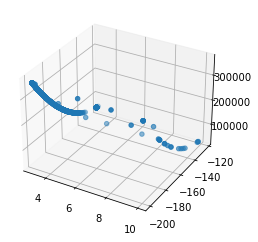

In [55]:
visualize_representation(car_problem,repr_ws).show()

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def visualize_two_representations(func,repr1,repr2):
    f_repr_1 = [func(repr1i[0],repr1i[1],repr1i[2]) for repr1i in repr1]
    f_repr_2 = [func(repr2i[0],repr2i[1],repr2i[2]) for repr2i in repr2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #Mark solutions to epsilon constsraint problem using crosses
    ax.scatter([f[0] for f in f_repr_1],[f[1] for f in f_repr_1],
               [f[2] for f in f_repr_1],marker='x')
    #Mark solutions to weighted sum problem using dots
    ax.scatter([f[0] for f in f_repr_2],[f[1] for f in f_repr_2],
               [f[2] for f in f_repr_2],marker='o')
    return plt

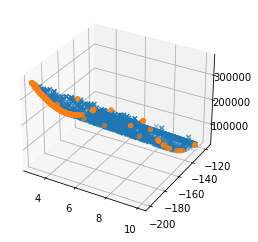

In [59]:
visualize_two_representations(car_problem,repr_eps,repr_ws).show()

**The weighting method can find all the Pareto optimal solutions only, when the objective functions are convex and the feasible set $S$ is convex.** 

**The weighting method can produce very unevenly spread Pareto optimal solutions, even when the problem is convex.** 

**The epsilon constraint method, however, adds constraints to the problem, which may make it much harder to solve**

## Note
During the last 15-20 years, evolutionary multiobjective optimization (EMO) approaches have become popular in multiobjective optimization. They
* operate on a population of solutions and their aim is to generate an approximation of the whole Pareto front (the set of all Pareto optimal solutions in the objective space),
* are very efficient in solving problems with 2-3 objective functions although they typically use a large number of function evaluations,
* are recently extended to work more efficiently for problems with more than 3 objective functions.

During the last 5-10 years, decision maker preferences are incorporated to the EMO algorithms to 1) improve convergence and 2) find solutions that are preferred by the decision maker.
* You can learn more about these approaches in the courses <a href="https://korppi.jyu.fi/kotka/course/student/generalCourseInfo.jsp?course=198768">TIES451 Selected topics in soft computing</a> and <a href="https://korppi.jyu.fi/kotka/r.jsp?course=198878">TIES598 Nonlinear Multiobjective Optimization</a>


## A priori methods

* A priori methods ask for preferences from the decision maker, and then find the Pareto optimal solution that best matches these preferences
* Benefits
  * If the decision maker knows what he/she wants and understands the preference information asked for, then application is fast
* Drawbacks
  * The decision maker may not know what he/she wants, because he does not know the Pareto optimal solutions
  * The decision maker may not understand how the preferences he/she gives affect the solutions found

## Achievement scalarizing problem

There are multiple versions of the achievement scalarizing problem, but all of them are based on a refence point.

A reference point
$$z^{ref} = (z^{ref}_1,\ldots,z^{ref}_k)$$
contains preferable values (so-called aspiration levels) for the objectives.



Then the achievement scalarizing problem maps this point and a feasible solution to the multiobjective problem to a scalar (i.e., scalarizes it). One of the most commonly used is

$$
\min_{x\in S}\left( \max_{i=1}^k[f_i(x)-z_i^{ref}] +\rho\sum_{i=1}^kf_i(x)\right)
$$

where $\rho>0$ is a small value. The second part is called an augmentation term.

**The solution to the problem is guaranteed to be Pareto optimal**

**Any (properly) Pareto optimal solution can be found with some reference point**

![alt text](images/ach.svg "Achievement scalarizing method")

### Application to our car problem

In [60]:
import numpy as np
from scipy.optimize import minimize
import ad
def asf(f,ref,z_ideal,z_nadir,rho):
    bounds = ((3,10),(50,200),(1000,4000)) #Bounds of the problem
    #Normalizing the reference point
    ref_norm = [(refi-z_ideali)/(z_nadiri-z_ideali) 
                for (refi,z_ideali,z_nadiri) in zip(ref,z_ideal,z_nadir)]
    def obj(x):
        return np.max(np.array(f(x[0],x[1],x[2]))-ref_norm)\
           +rho*np.sum(f(x[0],x[1],x[2]))
    start = [7,125,2500]
    res=minimize(
        #Objective function defined above
        obj, 
        start, method='SLSQP'
        #Jacobian using automatic differentiation
        ,jac=ad.gh(obj)[0]
        #bounds given above
        ,bounds = bounds,options = {'disp':True, 'ftol': 1e-20,
                                    'maxiter': 1000})
    return res

In [62]:
rho = 0.000001
#The reference point for the problem
ref =  [4,-60,12000] #To be added at the class
#ref =  z_ideal
res = asf(car_problem_normalized,ref,z_ideal,z_nadir,rho)
print("Solution is ",res.x)
print("Objective function values are ",car_problem(res.x[0],res.x[1],res.x[2]))
print(z_ideal)

Iteration limit reached    (Exit mode 9)
            Current function value: 0.041105710879986095
            Iterations: 1000
            Function evaluations: 10779
            Gradient evaluations: 1000
Solution is  [   4.27540441  117.54938247 2499.99708315]
Objective function values are  [4.275404407128466, -117.54938247197143, 54269.04362949268]
[3.0, -200.0, 5000]


## Interactive methods

* Interactive methods iteratively search for the preferred solution with decision maker and optimization alternating
* Benefits
  * Decision maker gets to learn about
    * the available solutions, and
    * how preferences affect the solutions found
  * Computation is less intensive, because no need to generate a large representation of Pareto optimal solutions
* Drawbacks
  * Needs active involvement from the decision maker
  * If the problem is computationally expensive, then the decision maker may need to wait a long time between solutions


## Interactive methods (cont)
The steps of the general algorithm are the following:
1. Initialize the solution process, e.g., calculate ideal and nadir objective vectors.
2. Generate initial Pareto optimal solution to be used as a current solution.
3. Show the current solution to the decision maker.
4. Ask the decision maker to provide preference information related to the current solution.
5. Generate new solution(s) based on the preference information.
6. Show the solutions generated in step 5 to the decision maker. Ask her/him to select the best solution of those and denote it as the current solution.
7. If the selected current solution is satisfactory for the decision maker, stop. Otherwise, continue from step 4.

## Interactive methods (cont)

**Interactive methods are one of the main research areas here at the Multiobjective optimization research group**

We will demonstrate interactive methods by using the open source DESDEO framework developed at the research group (https://desdeo.it.jyu.fi/). DESDEO includes implementations of several interactive methods.


### The synchronous NIMBUS Method

Introduced by Professors Kaisa Miettinen and Marko Mäkelä in 2006: 

<a href="https://www.sciencedirect.com/science/article/pii/S0377221704005260?casa_token=wEhNmXe5IQYAAAAA:ZXDms0f3S6J3568D-6ikVG3lHcYLLNaAPT04bBMF45nwUgTqrkpgWIsHhq77HyBfphpaNYad6ek">*Miettinen, K. and Mäkelä, M. M., Synchronous approach in interactive multiobjective optimization, European Journal of Operational Research, 170: 909-922, 2006*</a> 

Is based on classification of objectives into 
* those that should be improved as much as possible,
* those that should be improved until a given limit,
* those that are acceptable at the moment,
* those that can be allowed to worsen until a given limit,
* those that are allowed to move freely at the moment.

Synchronous NIMBUS is based on representing this information as four different single-objective optimization problems that are then solved and solutions are shown to the decision maker.


![alt text](images/NIMBUS_flow.png "NIMBUS Flowchart")

## A note

Reference point method: At each iteration, the decision maker provides a reference point and new solution is generated by using achievement scalarizing problem. Most of the subproblems in the synchronous NIMBUS method are based on this idea.


## Implementations of the NIMBUS method

There also exists a WWW-NIMBUS (https://wwwnimbus.it.jyu.fi/) web implementation (has not been maintained in more than 10 years, but works).

The Synchronous NIMBUS is implemented as a part of IND-NIMBUS (http://ind-nimbus.it.jyu.fi/) software framework. 

Recently, development of the DESDEO framework (https://desdeo.it.jyu.fi/) has been started to enable open-source framework for interactive multiobjective optimization (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9591595). 


## DESDEO framework

We will have a closer look at the DESDEO framework: https://desdeo.it.jyu.fi/

The following example is from https://desdeo-mcdm.readthedocs.io/en/latest/notebooks/synchronous_nimbus.html. We will have a look at it there. 

The same example can be found below if you want to try it by yourself. 

To install DESDEO you can use:

(!) pip install desdeo 

For more information see the GitHub page at https://github.com/industrial-optimization-group/DESDEO.

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from desdeo_problem.Problem import MOProblem
from desdeo_problem.Variable import variable_builder
from desdeo_problem.Objective import _ScalarObjective

def f_1(xs: np.ndarray):
    xs = np.atleast_2d(xs)
    xs_plusone = np.roll(xs, 1, axis=1)
    return np.sum(-10*np.exp(-0.2*np.sqrt(xs[:, :-1]**2 + xs_plusone[:, :-1]**2)), axis=1)

def f_2(xs: np.ndarray):
    xs = np.atleast_2d(xs)
    return np.sum(np.abs(xs)**0.8 + 5*np.sin(xs**3), axis=1)


varsl = variable_builder(
    ["x_1", "x_2", "x_3"],
    initial_values=[0, 0, 0],
    lower_bounds=[-5, -5, -5],
    upper_bounds=[5, 5, 5],
)

f1 = _ScalarObjective(name="f1", evaluator=f_1)
f2 = _ScalarObjective(name="f2", evaluator=f_2)

problem = MOProblem(variables=varsl, objectives=[f1, f2], ideal=np.array([-20, -12]), nadir=np.array([-14, 0.5]))

In [ ]:
from desdeo_mcdm.utilities.solvers import solve_pareto_front_representation

p_front = solve_pareto_front_representation(problem, step=1.0)[1]

plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

In [ ]:
from desdeo_mcdm.interactive.NIMBUS import NIMBUS

method = NIMBUS(problem, "scipy_de")

classification_request, plot_request = method.start()

In [ ]:
print(classification_request.content.keys())

In [ ]:
print(classification_request.content["message"])

In [ ]:
print(classification_request.content["objective_values"])

In [ ]:
print(classification_request.content["classifications"])

In [ ]:
response = {
    "classifications": ["<", ">="],
    "number_of_solutions": 3,
    "levels": [0, -5]
}
classification_request.response = response

In [ ]:
save_request, plot_request = method.iterate(classification_request)

In [ ]:
print(save_request.content.keys())
print(save_request.content["message"])
print(save_request.content["objectives"])

In [ ]:
response = {"indices": [0, 2]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

In [ ]:
print(intermediate_request.content.keys())
print(intermediate_request.content["message"])

In [ ]:
response = {"number_of_desired_solutions": 0, "indices": []}
intermediate_request.response = response

preferred_request, plot_request = method.iterate(intermediate_request)

In [ ]:
print(preferred_request.content.keys())
print(preferred_request.content["message"])

In [ ]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(preferred_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

In [ ]:
response = {"index": 1, "continue": True}
preferred_request.response = response

classification_request, plot_request = method.iterate(preferred_request)

In [ ]:
response = {
    "classifications": [">=", "<"],
    "number_of_solutions": 4,
    "levels": [-16, -1]
}
classification_request.response = response

save_request, plot_request = method.iterate(classification_request)

In [ ]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(save_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

In [ ]:
response = {"indices": [0, 1, 2, 3]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

In [ ]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(intermediate_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

In [ ]:
response = {
    "indices": [3, 4],
    "number_of_desired_solutions": 3,
    }
intermediate_request.response = response

save_request, plot_request = method.iterate(intermediate_request)

In [ ]:
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(save_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

In [ ]:
response = {"indices": [1]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

In [ ]:
response = {"number_of_desired_solutions": 0, "indices": []}
intermediate_request.response = response

preferred_request, plot_request = method.iterate(intermediate_request)

In [ ]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(preferred_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

In [ ]:
response = {
    "index": 6,
    "continue": False,
    }

preferred_request.response = response

print("hello")
print(preferred_request)

stop_request, plot_request = method.iterate(preferred_request)

print(stop_request)

In [ ]:
print(f"Final decision variables: {stop_request.content['solution']}")

plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
plt.scatter(stop_request.content["objective"][0], stop_request.content["objective"][1], label=f"final solution")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()